# Data Preprocess

In [458]:
import pandas as pd
from datetime import datetime

d = pd.read_csv('data.csv')

# Convert maturity column to datetime
d['Maturity_Date'] = pd.to_datetime(d['Maturity_Date'], format='%m/%d/%Y')
d['Issue_Date'] = pd.to_datetime(d['Issue_Date'], format='%m/%d/%Y')

# Compute days to maturity from today
today = datetime(2025, 1, 20)
d['Days_to_Maturity'] = (d['Maturity_Date'] - today).dt.days
d['Years_to_Maturity'] = d['Days_to_Maturity'] / 360

# Only keep the bonds within 5 year's maturity
d = d[(d['Days_to_Maturity'] >= 0) & (d['Days_to_Maturity'] <= 360*5)]

# Convert 'Coupon' column to numeric (remove '%' and convert to decimal)
d['Coupon'] = d['Coupon'].str.rstrip('%').astype(float)
print(d['Coupon'].value_counts())  # Shows frequency of each coupon rate

Coupon
3.000    3
2.250    3
3.500    3
4.000    3
1.000    2
1.500    2
3.750    2
1.250    2
3.250    2
4.500    2
9.000    1
8.000    1
0.500    1
3.245    1
2.750    1
0.250    1
2.000    1
5.750    1
Name: count, dtype: int64


# Bond Selection

In [459]:
# Find the most frequent coupon rate
common_coupon_rates = d['Coupon'].mode().tolist()
print(f"Most frequent coupon rates: {common_coupon_rates}")

common_coupon_rates = [common_coupon_rates[1], common_coupon_rates[2]]
print(f"We choose the middle values:{common_coupon_rates}")

Most frequent coupon rates: [2.25, 3.0, 3.5, 4.0]
We choose the middle values:[3.0, 3.5]


In [460]:
# Select bonds with the most frequent coupon rate(s)
filtered_bonds = d[d['Coupon'].isin(common_coupon_rates)]

# If too few bonds, expand range slightly (i.e., within ±0.5%)
if len(filtered_bonds) < 10:
    median_coupon = d['Coupon'].median()
    filtered_bonds = d[(d['Coupon'] >= median_coupon - 0.5) & (d['Coupon'] <= median_coupon + 0.5)]

# Ensure diversity in maturities
maturity_bins = [0, 360, 720, 1080, 1440, 1800]  # Days to maturity
labels = ['0-1Y', '1-2Y', '2-3Y', '3-4Y', '4-5Y']

# Assign each bond to a maturity bucket
filtered_bonds = filtered_bonds.copy()
filtered_bonds['Maturity_Bucket'] = pd.cut(filtered_bonds['Days_to_Maturity'], bins=maturity_bins, labels=labels)

# Pick up to 2 bonds per maturity bucket to get a balanced mix
selected_bonds = filtered_bonds.groupby('Maturity_Bucket').head(2)

# If fewer than 10 bonds, fill in remaining slots with the closest alternatives
if len(selected_bonds) < 10:
    additional_bonds = filtered_bonds[~filtered_bonds.index.isin(selected_bonds.index)].head(10 - len(selected_bonds))
    selected_bonds = pd.concat([selected_bonds, additional_bonds])

# Sort by Days_to_Maturity
selected_bonds = selected_bonds.sort_values(by='Days_to_Maturity')

# Display final selection
print(selected_bonds[['ISIN', 'Coupon', 'Maturity_Date', 'Years_to_Maturity', 'Maturity_Bucket']])

            ISIN  Coupon Maturity_Date  Years_to_Maturity Maturity_Bucket
22  CA135087Q640   3.500    2025-08-01           0.536111            0-1Y
18  CA135087P246   3.000    2025-10-01           0.705556            0-1Y
23  CA135087P816   3.000    2026-04-01           1.211111            1-2Y
4   CA135087S398   3.250    2026-11-01           1.805556            1-2Y
11  CA135087S547   3.000    2027-02-01           2.061111            2-3Y
17  CA135087P733   3.245    2027-08-24           2.627778            2-3Y
3   CA135087N837   2.750    2027-09-01           2.650000            2-3Y
32  CA135087P576   3.500    2028-03-01           3.155556            3-4Y
33  CA135087Q491   3.250    2028-09-01           3.666667            3-4Y
38  CA135087R895   3.500    2029-09-01           4.680556            4-5Y


<ipython-input-460-99456d1e3ba5>:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  selected_bonds = filtered_bonds.groupby('Maturity_Bucket').head(2)


# Yield to Maturity (YTM)

In [461]:
display(selected_bonds)

,ISIN,Issue_Date,Coupon,Maturity_Date,Jan 6,Jan 7,Jan 8,Jan 9,Jan 10,Jan 13,Jan 14,Jan 15,Jan 16,Jan 17,Jan 20,Days_to_Maturity,Years_to_Maturity,Maturity_Bucket
22,CA135087Q640,2023-05-12,3.500,2025-08-01,100.26,100.25,100.24,100.25,100.19,100.17,100.15,100.19,100.25,100.26,100.28,193,0.536111,0-1Y
18,CA135087P246,2022-07-25,3.000,2025-10-01,100.00,99.98,99.98,99.99,99.91,99.88,99.86,99.91,100.00,100.01,100.03,254,0.705556,0-1Y
23,CA135087P816,2023-01-20,3.000,2026-04-01,100.05,100.04,100.04,100.06,99.92,99.85,99.80,99.90,100.03,100.05,100.08,436,1.211111,1-2Y
4,CA135087S398,2024-08-02,3.250,2026-11-01,100.47,100.41,100.42,100.46,100.23,100.13,100.06,100.20,100.41,100.42,100.46,650,1.805556,1-2Y
11,CA135087S547,2024-11-01,3.000,2027-02-01,100.11,100.14,100.08,100.10,99.96,99.81,99.67,99.81,100.03,100.07,100.11,742,2.061111,2-3Y
17,CA135087P733,2022-12-02,3.245,2027-08-24,101.02,101.04,100.94,101.02,100.72,100.41,100.46,100.67,100.73,101.00,101.05,946,2.627778,2-3Y
3,CA135087N837,2022-05-13,2.750,2027-09-01,99.63,99.56,99.54,99.58,99.27,99.13,99.02,99.20,99.50,99.53,99.61,954,2.650000,2-3Y
32,CA135087P576,2022-10-21,3.500,2028-03-01,101.82,101.82,101.70,101.72,101.52,101.26,101.02,101.24,101.58,101.65,101.71,1136,3.155556,3-4Y
33,CA135087Q491,2023-04-21,3.250,2028-09-01,101.10,101.14,100.99,100.94,100.79,100.49,100.19,100.42,100.92,101.02,101.11,1320,3.666667,3-4Y
38,CA135087R895,2024-04-08,3.500,2029-09-01,102.22,102.14,102.04,101.98,101.59,101.28,101.00,101.27,101.85,101.97,102.13,1685,4.680556,4-5Y


,Jan 6,Jan 7,Jan 8,Jan 9,Jan 10,Jan 13,Jan 14,Jan 15,Jan 16,Jan 17,Jan 20
Years_to_Maturity,,,,,,,,,,,
0.536111,0.018955,0.018960,0.018966,0.018571,0.019578,0.019395,0.019601,0.018604,0.017209,0.016815,0.015833
0.705556,0.002466,0.002697,0.002532,0.002170,0.003586,0.003685,0.003916,0.002762,0.000821,0.000460,-0.000427
1.211111,0.015166,0.015183,0.015100,0.014816,0.016134,0.016585,0.017003,0.015917,0.014533,0.014250,0.029182
1.805556,0.019669,0.020012,0.019884,0.019555,0.021040,0.021531,0.021942,0.020938,0.019466,0.019338,0.018889
2.061111,0.026590,0.026392,0.026658,0.026512,0.027190,0.027835,0.028515,0.027749,0.026572,0.026324,0.025990
2.627778,0.026891,0.026771,0.027147,0.026779,0.027982,0.029156,0.028911,0.028003,0.027717,0.026564,0.026246
2.650000,0.027323,0.027583,0.027634,0.027436,0.028698,0.029188,0.029616,0.028831,0.027546,0.027389,0.026961
3.155556,0.026044,0.026010,0.026389,0.026287,0.026942,0.027738,0.028534,0.027740,0.026534,0.026260,0.025954
3.666667,0.027089,0.026943,0.027364,0.027486,0.027908,0.028726,0.029600,0.028881,0.027357,0.027032,0.026683


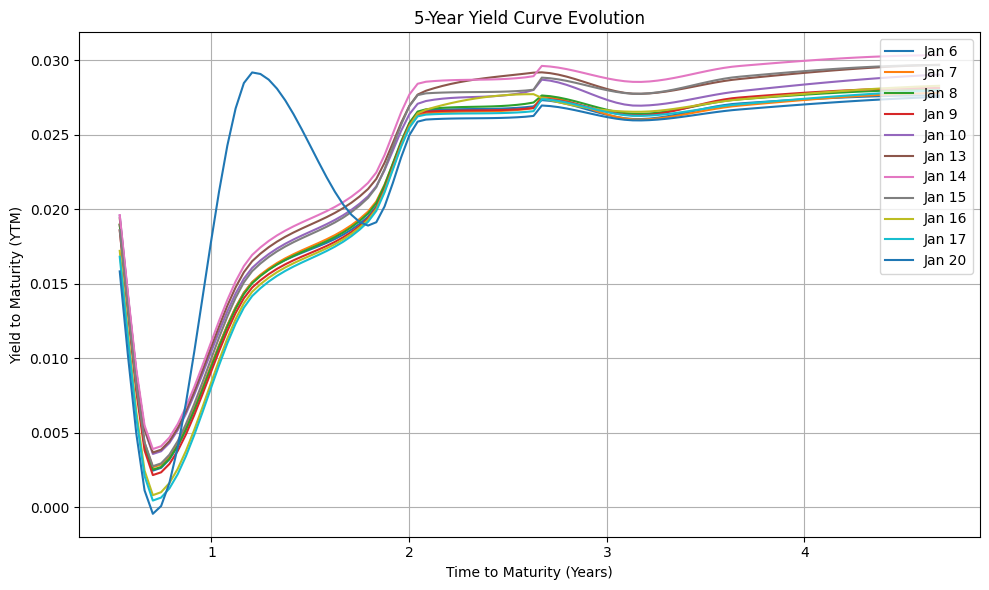

In [462]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton
from scipy.interpolate import PchipInterpolator


def calculate_accrued_interest(coupon_rate, last_coupon_date, observation_date, face_value=100):
    """
    Computes accrued interest using the observation date as the settlement date.
    If the observation date is exactly on a coupon payment date, accrued interest is zero.
    """
    if observation_date <= last_coupon_date:
        return 0  # No accrued interest if observation date is a coupon date

    days_since_last_coupon = (observation_date - last_coupon_date).days
    days_in_period = 180  # Adjusting to 180 days per semi-annual period

    semi_annual_coupon = (coupon_rate * face_value) / 2
    return semi_annual_coupon * (days_since_last_coupon / days_in_period)


def calculate_ytm_semi_annual(dirty_price, coupon_rate, maturity, face_value=100, accrued_interest=0):
    """
    Computes Yield to Maturity (YTM) for a bond with semi-annual coupons.
    Uses Newton-Raphson for solving, with a fallback to bisection if needed.
    """
    periods = int(maturity * 2)  # Semi-annual periods
    semi_annual_coupon = (coupon_rate * face_value) / 2

    # Define the bond pricing function to solve for YTM
    def ytm_equation(y):
        cash_flows = [semi_annual_coupon] * (periods - 1) + [semi_annual_coupon + face_value]
        present_value = sum(cf / (1 + y/2)**(t+1) for t, cf in enumerate(cash_flows))  # Price formula
        return present_value - dirty_price

    try:
        return newton(ytm_equation, x0=0.03)  # Initial guess: 3%

    except RuntimeError:
        # Fallback: Solve using a grid search + bisection
        ytm_guesses = np.linspace(0.01, 0.1, 50)
        errors = [abs(ytm_equation(y)) for y in ytm_guesses]
        return ytm_guesses[np.argmin(errors)]  # Choose best estimate


def get_last_coupon_date(issue_date, maturity_date, observation_date):
    """
    Find the most recent coupon date before or on the observation date.
    This takes into account the issue date, observation date, and maturity date.
    """
    last_coupon_date = issue_date + pd.DateOffset(months=6)  # First coupon date

    # Iterate over coupon dates until we exceed the observation date
    while last_coupon_date <= observation_date and last_coupon_date <= maturity_date:
        last_coupon_date += pd.DateOffset(months=6)

    # Step back 6 months if we exceeded the observation date
    if last_coupon_date > observation_date:
        last_coupon_date -= pd.DateOffset(months=6)

    return last_coupon_date

# Data preprocessing
selected_bonds['Coupon'] /= 100  # Convert to decimal (if coupon rates are in percentage form)
dates = ['Jan 6', 'Jan 7', 'Jan 8', 'Jan 9', 'Jan 10', 'Jan 13', 'Jan 14', 'Jan 15', 'Jan 16', 'Jan 17', 'Jan 20']
selected_bonds_dirty = selected_bonds.copy(deep=True)
ytms = {}


def month_name_to_number(month_name):
    return datetime.strptime(month_name, '%b').month


# Calculate YTMs
for date in dates:
    bond_ytms = []
    month_name, day = date.split()
    month_number = month_name_to_number(month_name)
    observation_date = pd.to_datetime(f'2025-{month_number}-{day}')  # Observation date

    for i, row in selected_bonds.iterrows():
        clean_price = row[date]  # Clean price for that date
        coupon_rate = row['Coupon']
        maturity = row['Years_to_Maturity']
        issue_date = pd.to_datetime(row['Issue_Date'])
        maturity_date = pd.to_datetime(row['Maturity_Date'])

        # Calculate the correct last coupon date based on observation date
        last_coupon_date = get_last_coupon_date(issue_date, maturity_date, observation_date)

        # Correctly calculate accrued interest based on observation date
        accrued_interest = calculate_accrued_interest(coupon_rate, last_coupon_date, observation_date)

        # Calculate dirty price (clean price + accrued interest)
        dirty_price = clean_price + accrued_interest
        selected_bonds_dirty.at[i, date] = dirty_price

        # Calculate the YTM using the dirty price
        ytm = calculate_ytm_semi_annual(dirty_price, coupon_rate, maturity, accrued_interest=accrued_interest)
        bond_ytms.append(ytm)

    ytms[date] = bond_ytms

# Convert results into a DataFrame
ytm_df = pd.DataFrame(ytms, index=selected_bonds['Years_to_Maturity'])
display(ytm_df)

# Plot yield curves
plt.figure(figsize=(10, 6))

# Interpolate and plot each date’s yield curve
for date in dates:
    x = ytm_df.index.values  # Maturities
    y = ytm_df[date].values  # YTMs
    sorted_idx = np.argsort(x)
    x_sorted, y_sorted = x[sorted_idx], y[sorted_idx]

    # Use PCHIP for smooth interpolation
    interpolator = PchipInterpolator(x_sorted, y_sorted)
    x_fine = np.linspace(min(x_sorted), max(x_sorted), 100)
    y_fine = interpolator(x_fine)

    plt.plot(x_fine, y_fine, label=date)

plt.title('5-Year Yield Curve Evolution')
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Yield to Maturity (YTM)')
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()


# Spot Rate

In [463]:
print(selected_bonds_dirty.columns)
display(selected_bonds_dirty)

Index(['ISIN', 'Issue_Date', 'Coupon', 'Maturity_Date', 'Jan 6', 'Jan 7',
       'Jan 8', 'Jan 9', 'Jan 10', 'Jan 13', 'Jan 14', 'Jan 15', 'Jan 16',
       'Jan 17', 'Jan 20', 'Days_to_Maturity', 'Years_to_Maturity',
       'Maturity_Bucket'],
      dtype='object')


,ISIN,Issue_Date,Coupon,Maturity_Date,Jan 6,Jan 7,Jan 8,Jan 9,Jan 10,Jan 13,Jan 14,Jan 15,Jan 16,Jan 17,Jan 20,Days_to_Maturity,Years_to_Maturity,Maturity_Bucket
22,CA135087Q640,2023-05-12,0.03500,2025-08-01,100.794722,100.794444,100.794167,100.813889,100.763611,100.772778,100.762500,100.812222,100.881944,100.901667,100.950833,193,0.536111,0-1Y
18,CA135087P246,2022-07-25,0.03000,2025-10-01,101.375000,101.363333,101.371667,101.390000,101.318333,101.313333,101.301667,101.360000,101.458333,101.476667,101.521667,254,0.705556,0-1Y
23,CA135087P816,2023-01-20,0.03000,2026-04-01,101.466667,101.465000,101.473333,101.501667,101.370000,101.325000,101.283333,101.391667,101.530000,101.558333,100.080000,436,1.211111,1-2Y
4,CA135087S398,2024-08-02,0.03250,2026-11-01,101.887361,101.836389,101.855417,101.904444,101.683472,101.610556,101.549583,101.698611,101.917639,101.936667,102.003750,650,1.805556,1-2Y
11,CA135087S547,2024-11-01,0.03000,2027-02-01,100.660000,100.698333,100.646667,100.675000,100.543333,100.418333,100.286667,100.435000,100.663333,100.711667,100.776667,742,2.061111,2-3Y
17,CA135087P733,2022-12-02,0.03245,2027-08-24,101.335486,101.364500,101.273514,101.362528,101.071542,100.788583,100.847597,101.066611,101.135625,101.414639,101.491681,946,2.627778,2-3Y
3,CA135087N837,2022-05-13,0.02750,2027-09-01,100.042500,99.980139,99.967778,100.015417,99.713056,99.595972,99.493611,99.681250,99.988889,100.026528,100.129444,954,2.650000,2-3Y
32,CA135087P576,2022-10-21,0.03500,2028-03-01,102.568611,102.578333,102.468056,102.497778,102.307500,102.076667,101.846389,102.076111,102.425833,102.505556,102.594722,1136,3.155556,3-4Y
33,CA135087Q491,2023-04-21,0.03250,2028-09-01,101.795139,101.844167,101.703194,101.662222,101.521250,101.248333,100.957361,101.196389,101.705417,101.814444,101.931528,1320,3.666667,3-4Y
38,CA135087R895,2024-04-08,0.03500,2029-09-01,103.095000,103.024722,102.934444,102.884167,102.503889,102.223056,101.952778,102.232500,102.822222,102.951944,103.141111,1685,4.680556,4-5Y


,0.536 Years,0.706 Years,1.211 Years,1.806 Years,2.061 Years,2.628 Years,2.65 Years,3.156 Years,3.667 Years,4.681 Years
Jan 6,0.025009,0.011333,0.018598,0.021949,0.028284,0.029403,0.026824,0.030480,0.030061,0.032582
Jan 7,0.025012,0.011416,0.018605,0.022100,0.028179,0.029336,0.026957,0.030461,0.029978,0.032681
Jan 8,0.025014,0.011357,0.018570,0.022044,0.028321,0.029539,0.026986,0.030670,0.030213,0.032804
Jan 9,0.024827,0.011227,0.018450,0.021900,0.028247,0.029347,0.026886,0.030619,0.030290,0.032886
Jan 10,0.025304,0.011734,0.019009,0.022549,0.028592,0.029971,0.027527,0.030959,0.030500,0.033393
Jan 13,0.025217,0.011769,0.019202,0.022766,0.028931,0.030594,0.027778,0.031392,0.030946,0.033774
Jan 14,0.025315,0.011852,0.019380,0.022946,0.029287,0.030458,0.027997,0.031824,0.031436,0.034151
Jan 15,0.024843,0.011439,0.018919,0.022509,0.028893,0.029987,0.027601,0.031403,0.031052,0.033778
Jan 16,0.024183,0.010744,0.018333,0.021869,0.028286,0.029856,0.026950,0.030763,0.030214,0.032969
Jan 17,0.023996,0.010615,0.018213,0.021815,0.028158,0.029243,0.026871,0.030616,0.030043,0.032798


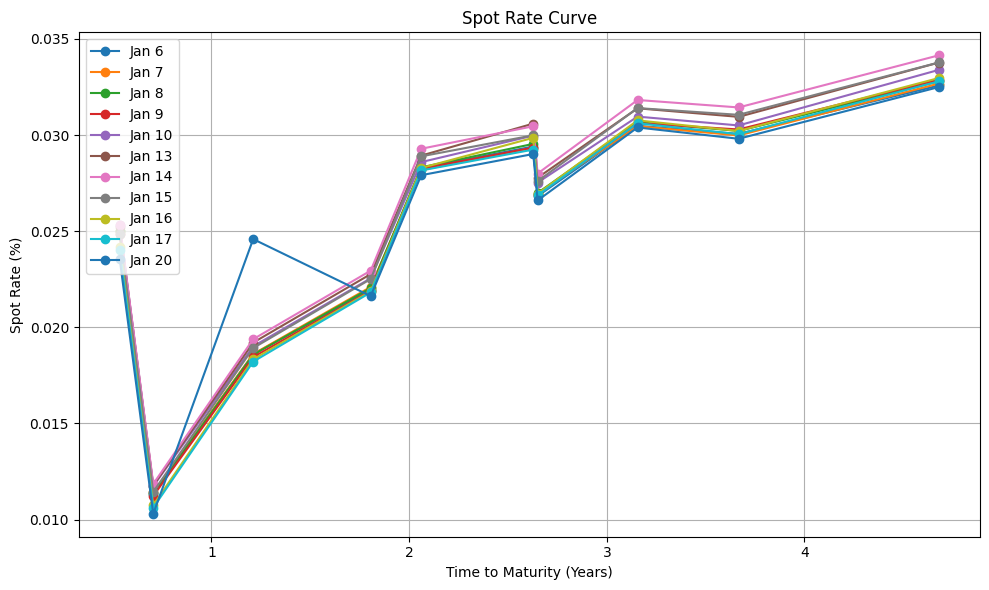

In [464]:
def bootstrap_spot_curve(selected_bonds, dates):
    spot_rates = {}
    face_value = 100

    # Iterate through each date
    for i, date in enumerate(dates):
        spot_rate_for_date = [0 for _ in range(len(selected_bonds))]
        idx = 0

        # Iterate through each bond to calculate the spot rates
        for _, row in selected_bonds.iterrows():
            dirty_price = row[date]
            coupon_rate = row['Coupon']
            maturity = row['Years_to_Maturity']

            # Create the bond's cash flows
            cash_flows = np.array([coupon_rate * face_value] * int(maturity * 2 - 1) + [coupon_rate * face_value + face_value])
            time_periods = np.arange(1, len(cash_flows) + 1) / 2  # Half-year intervals

            # Spot rate calculation using bootstrapping
            if len(cash_flows) == 1:
                # For the first bond, calculate the spot rate directly based on its actual maturity
                spot_rate = ( (face_value + coupon_rate * face_value) / dirty_price ) ** (1 / (2 * maturity)) - 1

            else:
                discounted_cash_flows = np.sum([
                    cf / (1 + spot_rate_for_date[j] / 2) ** (2 * time_periods[j])
                    for j, cf in enumerate(cash_flows[:-1])
                ])

                residual = dirty_price - discounted_cash_flows

                if residual <= 1e-6:  # Avoid division errors and negative residuals
                    spot_rate = spot_rate_for_date[idx - 1] * 1.01  # Small increase to previous rate
                else:
                    # Compute the spot rate using semi-annual compounding
                    spot_rate = ( (cash_flows[-1] / residual) ** (1 / (2 * maturity)) ) - 1

            spot_rate_for_date[idx] = spot_rate
            idx += 1

        # Store the spot rates for the current date using the index `i`
        spot_rates[i] = spot_rate_for_date

    return spot_rates


# Bootstrap spot curve for each date
spot_rates = bootstrap_spot_curve(selected_bonds_dirty, dates)

# Display spot rates as dataframe
spot_rates_df = pd.DataFrame.from_dict(spot_rates, orient="index")
spot_rates_df.columns = [f"{year} Years" for year in selected_bonds["Years_to_Maturity"].values.round(3)]
spot_rates_df.index = dates
display(spot_rates_df)

# Plot the spot rates
plt.figure(figsize=(10, 6))

# Plot each date’s spot rate curve using `i` as index
for i in range(len(dates)):
    if i in spot_rates:
        maturities = selected_bonds['Years_to_Maturity']
        plt.plot(maturities, spot_rates[i], marker='o', label=dates[i])
    else:
        print(f"Warning: No spot rate data for index {i}")

plt.title('Spot Rate Curve')
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Spot Rate (%)')
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Forward Rates


,1y1y,1y2y,1y3y,1y4y
Jan 6,0.038063,0.084220,0.118882,0.168480
Jan 7,0.037844,0.084155,0.118520,0.169041
Jan 8,0.038165,0.084836,0.119553,0.169746
Jan 9,0.038138,0.084738,0.119931,0.170244
Jan 10,0.038266,0.085514,0.120639,0.172960
Jan 13,0.038752,0.086777,0.122512,0.175066
Jan 14,0.039290,0.088050,0.124582,0.177159
Jan 15,0.038963,0.086963,0.123077,0.175175
Jan 16,0.038337,0.085254,0.119645,0.170751
Jan 17,0.038201,0.084854,0.118946,0.169817


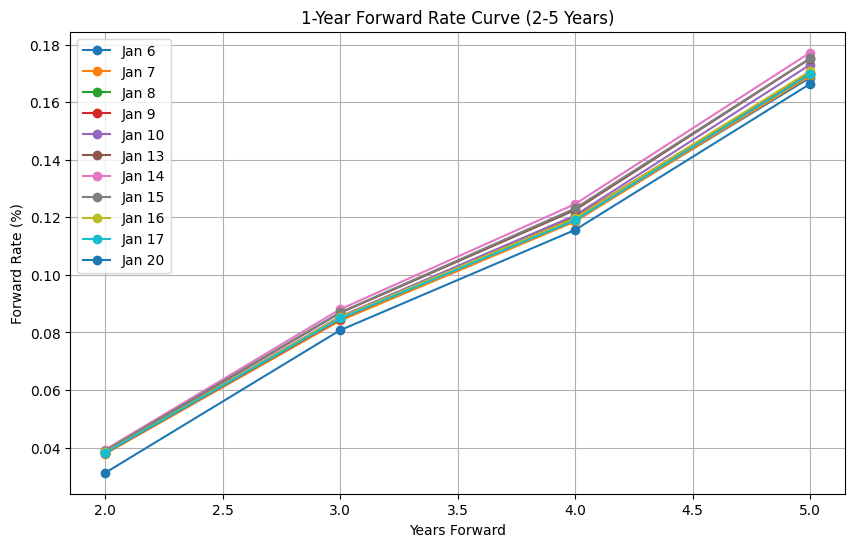

In [465]:
def compute_forward_rates(spot_rates_df, dates):
    """
    Computes 1-year forward rates for terms ranging from 1y1y to 1y4y.
    """
    forward_rates = {}

    # Extract years from the column names by removing the " Years" suffix and converting to float
    years = [float(col.split(' ')[0]) for col in spot_rates_df.columns]

    # Mapping the forward periods to their corresponding maturity terms
    target_periods = [1, 2, 3, 4]  # Corresponds to 1y1y, 1y2y, 1y3y, 1y4y

    for date in dates:
        forward_rates_for_date = []

        for n in target_periods:
            # Find the spot rate for the base year (t) and the next year (tn)
            t = 1  # Base year for all forward rates (1y1y, 1y2y, etc.)
            tn = t + n  # Ending year for the forward rate

            # Ensure tn is within the available years
            if tn > max(years):
                raise ValueError(f"Cannot compute forward rate for {tn} years: data not available.")

            # Extract the spot rate for the corresponding periods
            S_t = spot_rates_df.loc[date, f"{t} Years"]
            S_tn = spot_rates_df.loc[date, f"{tn} Years"]

            # Calculate the forward rate between t and tn using the annual compounding formula
            f_n1_n = ((1 + S_tn) ** tn) / ((1 + S_t) ** t) ** (1 / (tn - t)) - 1
            forward_rates_for_date.append(f_n1_n)

        forward_rates[date] = forward_rates_for_date

    # Create DataFrame for forward rates with proper indices
    forward_rates_df = pd.DataFrame(forward_rates, index=["1y1y", "1y2y", "1y3y", "1y4y"]).T

    return forward_rates_df


# Only keep the related spot rates with the maturities of 1.211 Years, 2.061 Years, 3.156 Years, 3.667 Years
spot_rates_df_cut = spot_rates_df.copy()
spot_rates_df_cut = spot_rates_df_cut.loc[:, ['1.211 Years', '2.061 Years', '3.156 Years', '3.667 Years', '4.681 Years']]

# Change the column names as 1 Years, 2 Years, etc.
spot_rates_df_cut.columns = ["1 Years", "2 Years", "3 Years", "4 Years", "5 Years"]

# Compute forward rates
dates = spot_rates_df_cut.index
forward_rates_df = compute_forward_rates(spot_rates_df_cut, dates)
display(forward_rates_df)

# Plot forward curves
plt.figure(figsize=(10, 6))
for date in dates:
    plt.plot([2, 3, 4, 5], forward_rates_df.loc[date], marker='o', label=date)

plt.title("1-Year Forward Rate Curve (2-5 Years)")
plt.xlabel("Years Forward")
plt.ylabel("Forward Rate (%)")
plt.grid(True)
plt.legend(loc='upper left')
plt.show()


# Covariance Matrix

In [480]:
def compute_log_returns(data):
    return np.log(data / data.shift(1)).dropna()

ytm_df_cut = ytm_df.T.copy()
ytm_df_cut.columns = [f"{round(col, 3)} Years" if isinstance(col, (int, float)) else col for col in ytm_df_cut.columns]
ytm_df_cut = ytm_df_cut.loc[:, ['1.211 Years', '2.061 Years', '3.156 Years', '3.667 Years', '4.681 Years']]
ytm_df_cut.columns = ["1 Years", "2 Years", "3 Years", "4 Years", "5 Years"]

# Compute log-returns for yields and forward rates
yield_log_returns = compute_log_returns(ytm_df_cut)
forward_log_returns = compute_log_returns(forward_rates_df)

# Compute covariance matrices
yield_cov_matrix = yield_log_returns.cov()
forward_cov_matrix = forward_log_returns.cov()

# Print results
print("Covariance Matrix for Yield Log-Returns:")
display(yield_cov_matrix)

print("\nCovariance Matrix for Forward Rate Log-Returns:")
display(forward_cov_matrix)

Covariance Matrix for Yield Log-Returns:


,1 Years,2 Years,3 Years,4 Years,5 Years
1 Years,0.054782,0.000189,0.000169,0.000126,-0.000161
2 Years,0.000189,0.000530,0.000566,0.000580,0.000535
3 Years,0.000169,0.000566,0.000611,0.000628,0.000574
4 Years,0.000126,0.000580,0.000628,0.000677,0.000593
5 Years,-0.000161,0.000535,0.000574,0.000593,0.000577



Covariance Matrix for Forward Rate Log-Returns:


,1y1y,1y2y,1y3y,1y4y
1y1y,0.004143,0.001111,0.000700,0.000540
1y2y,0.001111,0.000377,0.000291,0.000241
1y3y,0.000700,0.000291,0.000263,0.000219
1y4y,0.000540,0.000241,0.000219,0.000201


# Eigenvalues & Eigenvectors

In [482]:
# Compute eigenvalues and eigenvectors for yield covariance matrix
yield_eigenvalues, yield_eigenvectors = np.linalg.eig(yield_cov_matrix)

# Compute eigenvalues and eigenvectors for forward rate covariance matrix
forward_eigenvalues, forward_eigenvectors = np.linalg.eig(forward_cov_matrix)

# Print eigenvalues and eigenvectors
print("Eigenvalues for Yield Covariance Matrix:")
print(yield_eigenvalues)

print("\nEigenvectors for Yield Covariance Matrix:")
print(yield_eigenvectors)

print("\nEigenvalues for Forward Rate Covariance Matrix:")
print(forward_eigenvalues)

print("\nEigenvectors for Forward Rate Covariance Matrix:")
print(forward_eigenvectors)

Eigenvalues for Yield Covariance Matrix:
[5.47835140e-02 2.34048327e-03 3.12646046e-05 1.89860905e-05
 2.36196315e-06]

Eigenvectors for Yield Covariance Matrix:
[[-9.99981942e-01  3.11490647e-03 -3.75866521e-03  3.48205066e-03
  -4.00732877e-04]
 [-3.50922352e-03 -4.72450271e-01 -5.77998261e-02 -5.70515943e-01
   6.69290046e-01]
 [-3.15398914e-03 -5.08416877e-01  8.26281548e-02 -4.46003664e-01
  -7.31953313e-01]
 [-2.36509421e-03 -5.30026123e-01  6.58095766e-01  5.19774486e-01
   1.25742445e-01]
 [ 2.87393499e-03 -4.87201835e-01 -7.46141812e-01  4.53226930e-01
  -2.19967876e-02]]

Eigenvalues for Forward Rate Covariance Matrix:
[4.66158800e-03 3.09171104e-04 2.87808034e-06 1.00616930e-05]

Eigenvectors for Forward Rate Covariance Matrix:
[[ 0.93916729  0.31551034  0.13048043  0.03732123]
 [ 0.26303726 -0.41244323 -0.86577012 -0.10556556]
 [ 0.17368179 -0.61697301  0.42465216 -0.63941339]
 [ 0.13642149 -0.59134433  0.23040725  0.76066652]]
